In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

**PreProcess For Datasets**

In [54]:
lst_dataframes=[]
lst_dataframes_mix=[]
lst_metrics=['CharHitAt','WordHitAt']
c=0
for j in lst_metrics:
    for k in [1,5]:

     lst_dataframes.append(pd.read_csv('baseline2-'+j+str(k)+'.csv'))
     lst_dataframes.append(pd.read_csv('ensemble-'+j+str(k)+'_spaces_known'+'.csv'))
     lst_dataframes_mix.append(pd.read_csv('baseline2-'+j+str(k)+'_mix'+'.csv'))
     lst_dataframes_mix.append(pd.read_csv('ensemble-'+j+str(k)+'_mix'+'.csv'))

     if j=='WordHitAt':
      lst_dataframes.append(pd.read_csv('baseline1-'+j+str(k)+'.csv'))
      lst_dataframes_mix.append(pd.read_csv('baseline1-'+j+str(k)+'_mix'+'.csv'))

In [55]:
def change_masking_values(lst_dataframes):
  new_df=[]
  for i in lst_dataframes:
    i['file'] = i['file'].str.rsplit('/', n=1, expand=True)[1]
    i['file'] = i['file'].str.replace('json', '')
    lst_maskes=[]

    for masking in i['file']:
        if 'mix_5.' in masking or 'MIX_validation_df_no_spaces_5' in masking:
          lst_maskes.append('5% Mask')
        if 'mix_10.' in masking or 'MIX_validation_df_no_spaces_10' in masking:
          lst_maskes.append('10% Mask')
        if 'mix_15.' in masking or 'MIX_validation_df_no_spaces_15' in masking:
          lst_maskes.append('15% Mask')

    i['file']=lst_maskes

    new_df.append(i)

  return new_df

In [56]:
new_df_=change_masking_values(lst_dataframes)
new_df_mix=change_masking_values(lst_dataframes_mix)

In [94]:
def create_metrics_df(new_df):
  dfs3 = [new_df[0], new_df[1]]
  Char_Hit1_baseline2 = pd.concat(dfs3, axis=0, ignore_index=True)

  dfs4= [new_df[2], new_df[3]]
  Char_Hit5_baseline2 = pd.concat(dfs4, axis=0, ignore_index=True)

  dfs5= [new_df[4], new_df[5]]
  Word_Hit1_baseline2 = pd.concat(dfs5, axis=0, ignore_index=True)

  dfs6= [new_df[7], new_df[8]]
  Word_Hit5_baseline2 = pd.concat(dfs6, axis=0, ignore_index=True)

  dfs7= [new_df[6], new_df[5]]
  Word_Hit1_baseline1 = pd.concat(dfs7, axis=0, ignore_index=True)

  dfs8= [new_df[9], new_df[8]]
  Word_Hit5_baseline1 = pd.concat(dfs8, axis=0, ignore_index=True)

  return [Char_Hit1_baseline2,Char_Hit5_baseline2,Word_Hit1_baseline2,Word_Hit5_baseline2,Word_Hit1_baseline1,Word_Hit5_baseline1]


In [96]:
lst_metrics=create_metrics_df(new_df_)
lst_metrics_mix=create_metrics_df(new_df_mix)

In [127]:
def best_models_unique_names(lst_metrics,names):
  lst_merges_by_metric=[]
  for df in lst_metrics:
    df=df.loc[df['model'].isin(names)]
    lst_merges_by_metric.append(df)

  unique_values=[]
  for name in list(lst_merges_by_metric[2].model.unique()):
    if name==names[3]:
      unique_values.append('Ensemble')
    else:
      unique_values.append(name.split('/')[1].split('-')[0])
      unique_values[0]='AlephBertG'

  return lst_merges_by_metric,unique_values

In [129]:
lst_merges_by_metric,unique_values=best_models_unique_names(lst_metrics,['Embible/AlephBertGimmel-20-epochs','Embible/mBert-50-epochs','Embible/distilBert-50-epochs','Spaces_Known'])
lst_merges_by_metric_mix,unique_values_mix=best_models_unique_names(lst_metrics_mix,['Embible/AlephBertGimmel-20-epochs','Embible/mBert-50-epochs','Embible/distilBert-50-epochs','EnsembleV2'])

## **Baseline 2 Models Results :**

In [130]:
def plot_Compare_result_ensemble_finetune(lst_merges_by_metric,colors1,unique_values,model_name):
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
  flag=False
  index=0
  for i,eval in enumerate(['Char','Word']):
      if i==1:
          index+=2
      for j,k in enumerate([1,5]):
        sns.barplot(x='file', y='hit@k',data=lst_merges_by_metric[j+index],hue='model',palette=colors1, ax=axs[i,j])
        axs[i,j].set_title(eval+ "Hit@"+str(k), fontsize=10, fontweight="bold")
        axs[i,j].set_xlabel("Percentage Of Masking Dataset", fontsize=8)
        axs[i,j].set_ylabel("Hit@"+str(k), fontsize=12)
        axs[i,j].legend([], frameon=False)

  legend_elements2 = [plt.Line2D([0], [0],marker='o', color='w', label=unique_values[0], markerfacecolor=colors1[0], markersize=6),
                      plt.Line2D([0], [0], marker='o', color='w', label=unique_values[1], markerfacecolor=colors1[1], markersize=6),
                      plt.Line2D([0], [0],marker='o', color='w', label=unique_values[2], markerfacecolor=colors1[2], markersize=6),
                      plt.Line2D([0], [0],marker='o', color='w', label=unique_values[3], markerfacecolor=colors1[3], markersize=6)]
  fig.legend(handles=legend_elements2,loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=4,title='Model')


  fig.suptitle(model_name, fontsize=20)

  fig.savefig("baseline2results.png")

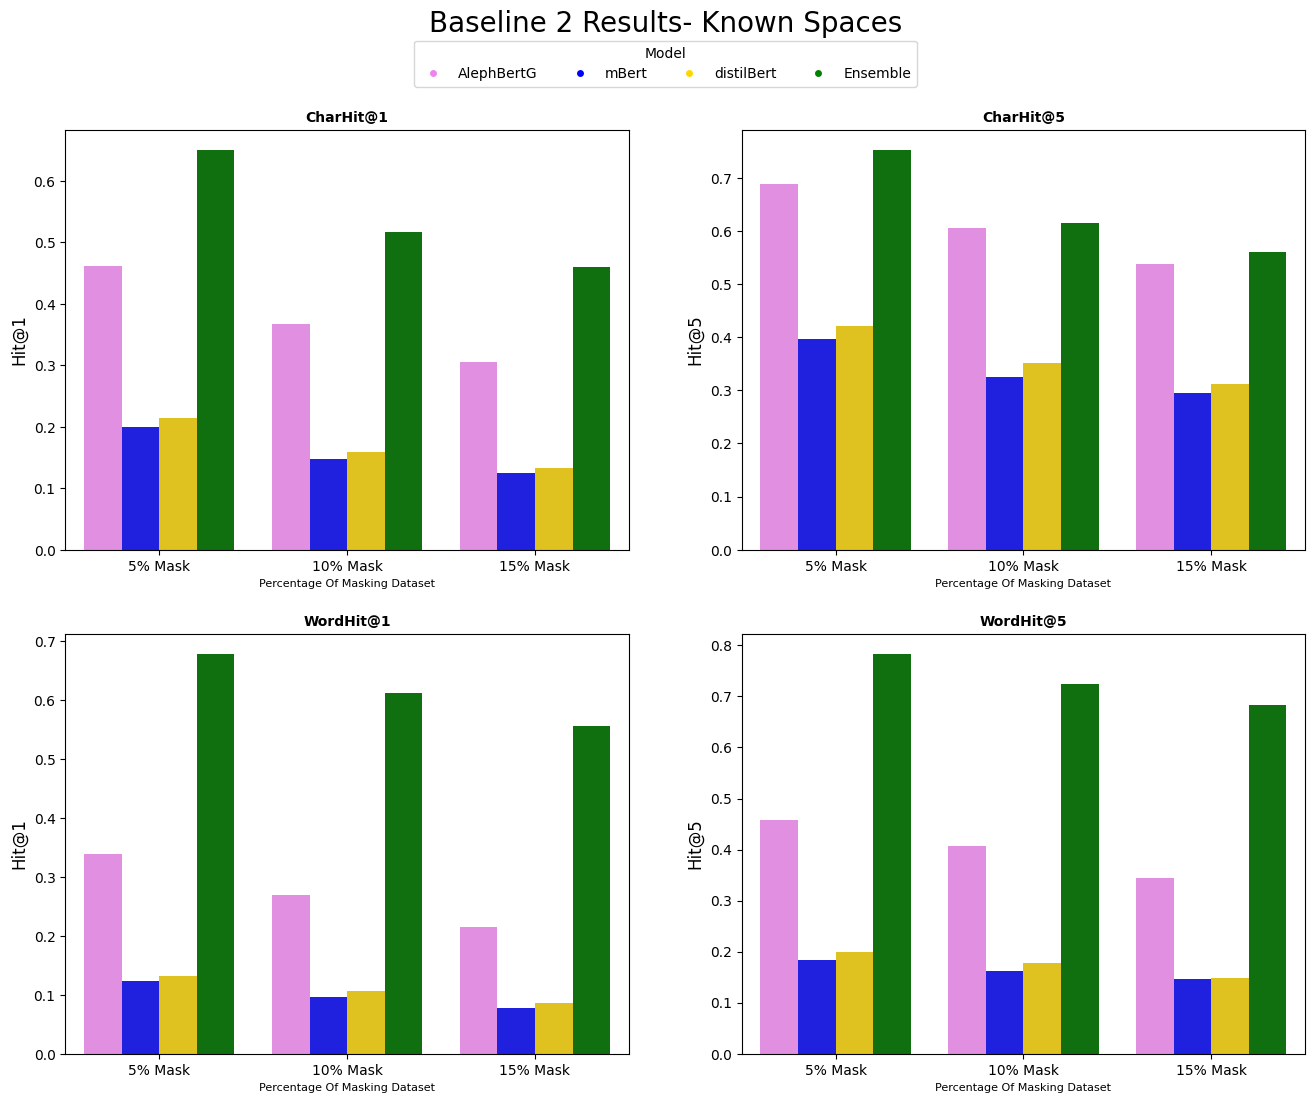

In [131]:
plot_Compare_result_ensemble_finetune(lst_merges_by_metric,["violet", "blue","gold",'green'],unique_values,'Baseline 2 Results- Known Spaces')

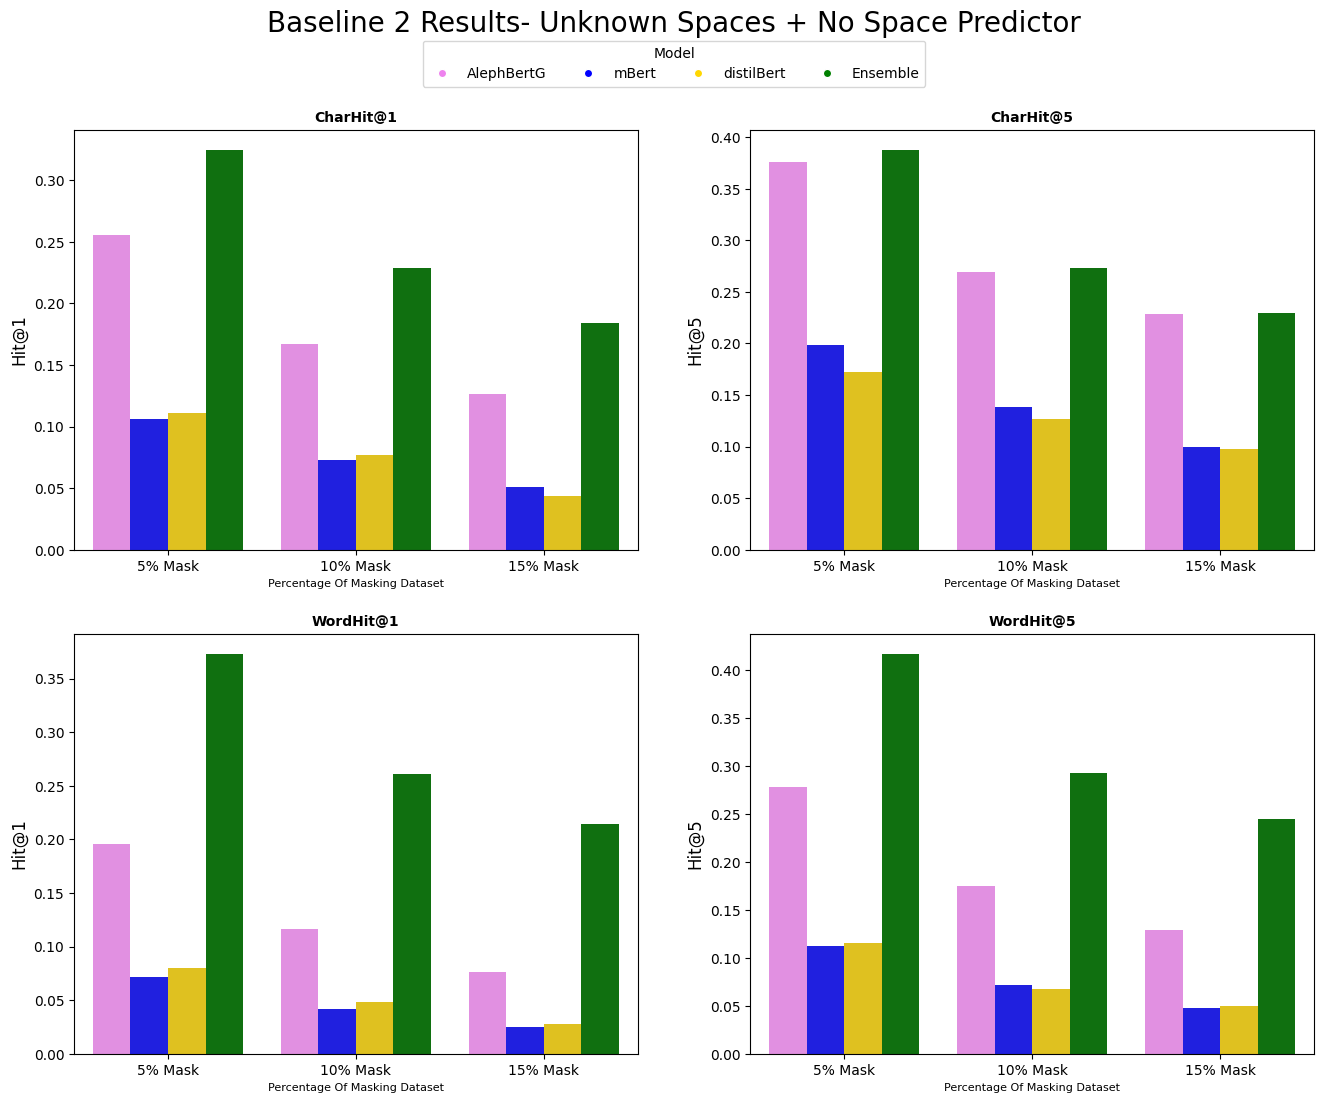

In [132]:
plot_Compare_result_ensemble_finetune(lst_merges_by_metric_mix,["violet", "blue","gold",'green'],unique_values_mix,'Baseline 2 Results- Unknown Spaces + No Space Predictor')

## **Baseline 1 Graph:**

In [133]:
def plot_Baseline1(lst_merges_by_metric,colors1,unique_values,model_name):
  fig, axs = plt.subplots(1, 2, figsize=(12, 8))
  flag=False
  for i,eval in enumerate(['Word']):
      for j,k in enumerate([1,5]):
        sns.barplot(x='file', y='hit@k',data=lst_merges_by_metric[j],hue='model',palette=colors1, ax=axs[j])
        axs[j].set_title(eval+ "Hit@"+str(k), fontsize=10, fontweight="bold")
        axs[j].set_xlabel("Percentage Of Masking Dataset", fontsize=8)
        axs[j].set_ylabel("Hit@"+str(k), fontsize=12)
        axs[j].legend([], frameon=False)


  legend_elements2 = [plt.Line2D([0], [0],marker='o', color='w', label=unique_values[0], markerfacecolor=colors1[0], markersize=6),
                      plt.Line2D([0], [0], marker='o', color='w', label=unique_values[1], markerfacecolor=colors1[1], markersize=6),
                      plt.Line2D([0], [0],marker='o', color='w', label=unique_values[2], markerfacecolor=colors1[2], markersize=6),
                      plt.Line2D([0], [0],marker='o', color='w', label=unique_values[3], markerfacecolor=colors1[3], markersize=6)]
  fig.legend(handles=legend_elements2,loc='upper center', bbox_to_anchor=(0.5, 0.96),handlelength=0.05, borderpad=0.01,labelspacing=0.5, ncol=4,title='Model')



  fig.suptitle(model_name, fontsize=20,y=0.99)
  fig.savefig("baseline1results.png")

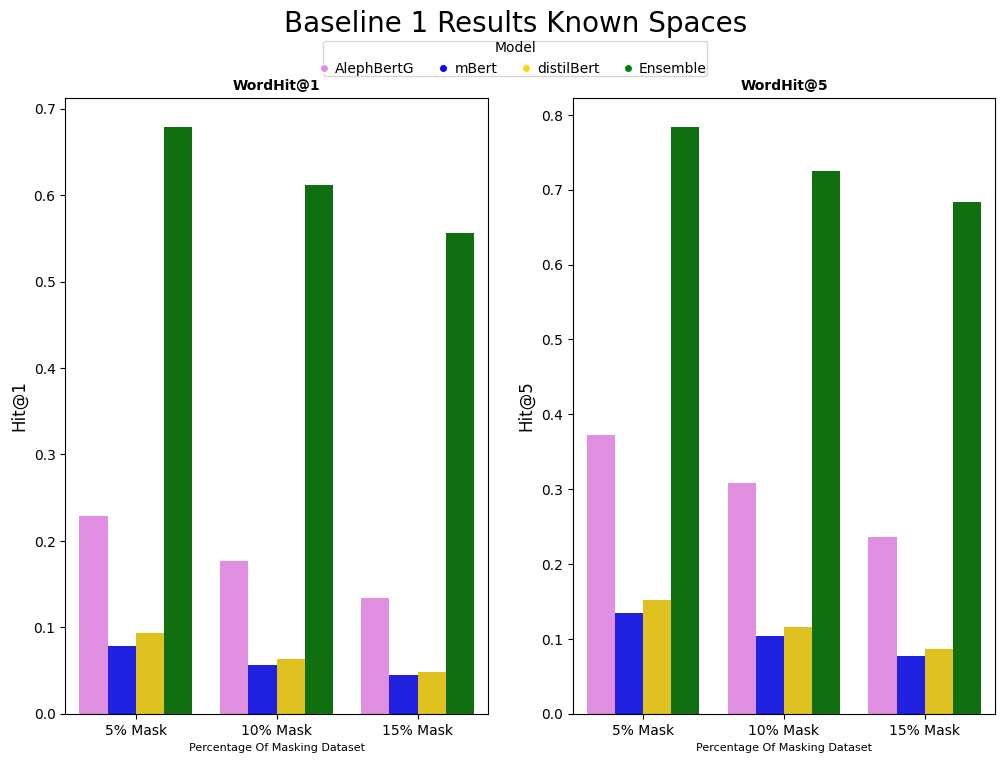

In [120]:
plot_Baseline1([lst_merges_by_metric[4],lst_merges_by_metric[5]],["violet", "blue","gold","green"],unique_values,'Baseline 1 Results Known Spaces')

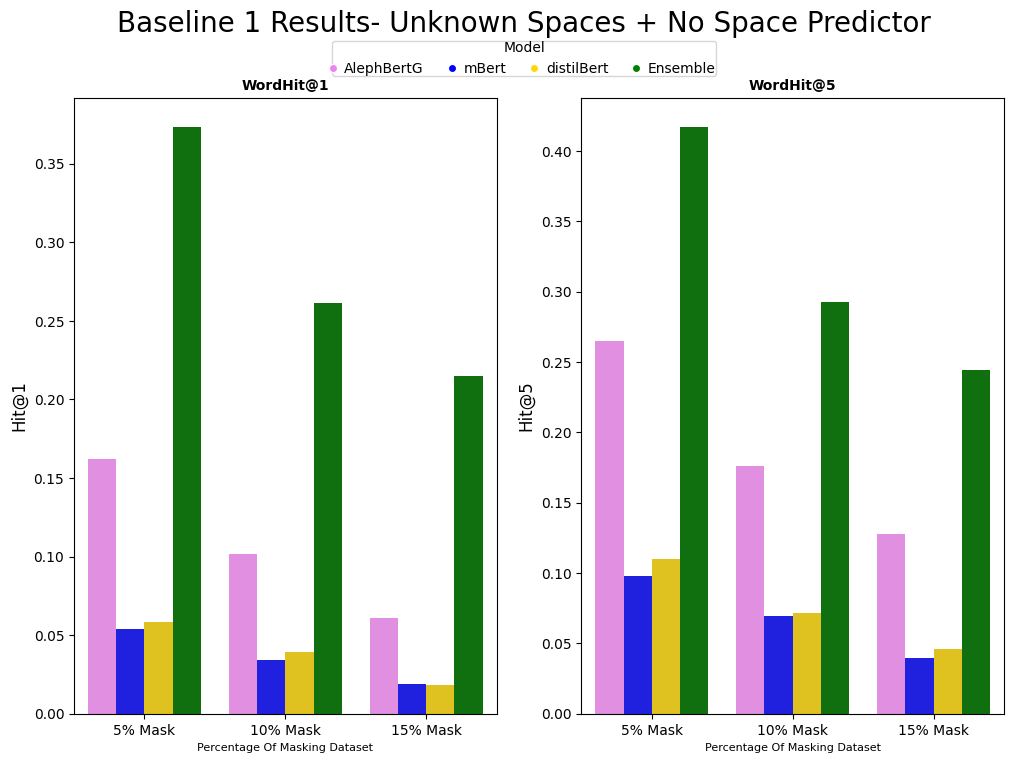

In [134]:
plot_Baseline1([lst_merges_by_metric_mix[4],lst_merges_by_metric_mix[5]],["violet", "blue","gold","green"],unique_values,'Baseline 1 Results- Unknown Spaces + No Space Predictor')